In [1]:
import nltk
import pandas as pd
import random
import numpy as np
import string
import math

from nltk import ngrams
from nltk.corpus import stopwords
from nltk.stem.snowball import FrenchStemmer
from nltk.tokenize import word_tokenize

from numpy import array
from collections import Counter
from scipy.sparse import csr_matrix

from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from gensim.test.utils import common_dictionary, common_corpus
from gensim.models import LsiModel
from gensim import corpora, models, utils
from gensim.test.utils import common_corpus, common_dictionary, get_tmpfile
from gensim.models import LsiModel
from gensim.corpora import Dictionary

import networkx as nx

import re

In [2]:
# Use spacy lib
# On https://spacy.io/

import spacy
nlp = spacy.load('fr')

In [3]:
##############
# Parameters #
##############

min_gram = 1
max_gram = 3

# To create ours partitions, we must first know the years which will be the limits
limit_years = [2007, 2010, 2013, 2016]

# Ignore words that appear at a frequency more than max_frequ in the corpus
max_frequ = 0.8

# Ignore words appearing less than min_appear in the whole corpus
min_appear = 20

# Range fo cluster number you want to test
cluster_ranges = range(2, 30) #range(2, 100) # Warning, long to compute (but nice)

# Number of trial you want to do for each test
nb_trial_by_test = 3

# Number of cluster you finally choose
nb_cluster = 10

# Max iteration for each kmeans (default: 300)
max_iter = 300

In [4]:
# Datas preprocessing methods.

# Lemmatisation without poncutations

stemmer = nltk.stem.snowball.FrenchStemmer()
fstw = stopwords.words('french')

# French Stop Words, extraits depuis le fichier stopwords-fr.txt + stopwords french de nltk
sourceFST = [x.replace('\n', '') for x in open('stopwords-fr.txt', mode="r", encoding="utf-8").readlines()]+fstw
sourceFST += [x.replace('\n', '') for x in open('perso_words-fr.txt', mode="r", encoding="utf-8").readlines()]

# Based on ration of french and english stopwords
def isEnglish(article):
    total_fsw = len([x for x in article.split() if x in sourceFST])
    total_esw = len([x for x in article.split() if x in stopwords.words('english')])
    ratio = 100
    if total_fsw != 0:
        ratio = total_esw/total_fsw
    return ratio > 1 and total_esw > 3

def lemmatize(article):
    arti_lower = article.lower()
    arti_2words = re.sub(" [0-z][0-z] ", " ", arti_lower) # word of length < 2
    arti_e = re.sub("(é|è|ê)", "e", arti_2words)
    arti_o = re.sub("à", "a", arti_e)
    arti_i = re.sub("ô", "o", arti_o)
    artiregex = re.sub("î", "i", arti_i)
    output = []
    outPonc = artiregex.translate(artiregex.maketrans("","", string.punctuation))
    outLem = nlp(outPonc)
    for token in outLem:
        if token.lemma_ not in sourceFST and [x for x in token.lemma_ if x not in "0123456789"] != []:
            output.append(token.lemma_)
    res = ' '.join(output)
    return res

In [5]:
# Data Reading
data = pd.read_csv('export_articles_EGC_2004_2018.csv', sep='\t', header=0)

In [6]:
# Let's process our corpus, and determine a limit to split it in partitions

# limits[] let us know when to delimit partitions
temp_usable = []

prev_year = data['year'][0]
numArti = 0
for i in range(0, len(data['abstract']), 1):
    #if not null, empty, or whatever (so if there is a abstract):
    if isinstance(data['abstract'][i], float) or isEnglish(data['abstract'][i]):
        temp_usable.append([])
    else:
        text = data['abstract'][i]
        if not isinstance(data['title'][i], float):
            text += " "+data['title'][i]

        numArti+=1
        temp_usable.append(re.sub(" [0-z][0-z] ", " ", stemmer.stem(lemmatize(text))))



In [7]:
# Post-process word removal
post_words = [x.replace('\n', '') for x in open('post_process_words-fr.txt', mode="r", encoding="utf-8").readlines()]

for i in range(0, len(temp_usable)):
    if len(temp_usable[i]) != 0:
        arti = temp_usable[i].split()
        res = []
        for word in arti:
            if word not in post_words:
                res.append(word)
        temp_usable[i] = ' '.join(res)

In [8]:
# Limit computing

# limits[] let us know when to delimit partitions
# the number into limits represent the document numero that is not included in the previous bound
limits = []
usable = []

prev_year = data['year'][0]
numArti = 0
for i in range(0, len(temp_usable)):
    #if not null, empty, or whatever (so if there is a abstract):
    if not isinstance(temp_usable[i], float) and not len(temp_usable[i]) == 0 and not isEnglish(temp_usable[i]):
        usable.append(temp_usable[i])
        numArti += 1
        year = data['year'][i]
        if year != prev_year:
            prev_year = year
            if year in limit_years:
                limits.append(numArti)
limits.append(numArti)

In [9]:
# Display pre-processed datas

vectorizer = TfidfVectorizer(stop_words=sourceFST, use_idf=True, ngram_range=(min_gram, max_gram), max_df=max_frequ, min_df=min_appear)
tfidf = vectorizer.fit_transform(usable)

print("nombre d'articles =", len(usable))
print("nombre de mots =", len(tfidf.toarray()[0]))
print("limits =", limits)

usable

nombre d'articles = 991
nombre de mots = 439
limits = [114, 301, 468, 694, 991]


['plateforme objectif citoyen tweet politique devenement specifiqu lelection presidentiell ideo2017 analyser quasitemps reel message candidat fournir principal caracteristiqueslusage lexiqu politique comparaison candidat ideo2017 plateforme citoyen dediee lanalyse tweet evenement polit',
 'classification coclustering technique dextraire structuresousjacente existant ligne colonne tabler donneer former bloc application technique algorithme coclustering actuel passer lechelle approche succe modl optimiser critere vraisemblance regularisee cependent taille important methode atteindre limiter article algorithme coclustering niveau compter critere modl traiter efficacement grand tailler pouvoir memoir experience lapproche gagn temps calcul solution qualite two level coclustering very large dater set',
 'recommandation point dinteret caracteristiqueessentielle reseaux social geolocalise accompagnelemergence echange massif digital cependantle faible densit point dinteret visiter utilisateur r

In [10]:
# Creation of partitions_tfidf[], which give us the TFIDF of each cluster of each partition
# partitions_tfidf[num_partition][num_doc][num_word]
# Beware, num_doc can't be equals to 1091 (max). You have partitions, so every doc aren't in every partitions
# num_word can be found via vectorizer.get_feature_name()
partitions_tfidf = []
beg = 0
for l in limits:
    last = l
    partitions_tfidf.append([list(x) for x in list(tfidf.toarray())[beg:last]])
    beg = l

# KMeans & Silhouette Score

In [11]:
# Applying KMeans on tfidf
# the labels_ give assignment of doc to the cluster number 


In [12]:
# SOURCE :
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html


# Silhouette analysis can be used to study the separation distance between the resulting clusters.
# The silhouette plot displays a measure of how close each point in one cluster is to points in 
# the neighboring clusters and thus provides a way to assess parameters like number of clusters visually.
# This measure has a range of [-1, 1].

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

In [13]:
def kmeans_silhouette(samples, k):
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(random_state = 1 ,n_clusters=k, max_iter=800, init='k-means++', n_init=50, n_jobs=-1)
    cluster_labels = clusterer.fit_predict(samples)

    silhouette_avg = silhouette_score(samples, cluster_labels)
    sample_silhouette_values = silhouette_samples(samples, cluster_labels)

    return {'k':k, 'cluster':clusterer, 'labels':cluster_labels ,'silhouette_avg':silhouette_avg, 'sample_silhouette_values':sample_silhouette_values }


def kmeans_silhouette_range(samples, k_min, k_max):
    kmeans_silhouette_range_value = {}
    for k in range(k_min, k_max):
        kmeans_silhouette_range_value[k] = kmeans_silhouette(samples, k)
    return kmeans_silhouette_range_value


In [14]:
def display_kmeans_silhouette(kmeans_silhouette_value):
    clusterer = kmeans_silhouette_value['cluster']
    cluster_labels = kmeans_silhouette_value['labels']
    silhouette_avg = kmeans_silhouette_value['silhouette_avg']
    sample_silhouette_values = kmeans_silhouette_value['sample_silhouette_values']
    n_cluster = kmeans_silhouette_value['k']

    print("For n_cluster =", n_cluster,
              "The average silhouette_score is :", silhouette_avg)

    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(cluster_labels) + (n_cluster + 1) * 10])

    y_lower = 10
    for i in range(n_cluster):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_cluster)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for cluster = %d" % n_cluster),
                 fontsize=14, fontweight='bold')
    plt.show()

In [15]:
X = tfidf.toarray()
k_s_r = kmeans_silhouette_range(X, 8, 20)

In [16]:

k_s= kmeans_silhouette(X, 10)

For n_cluster = 10 The average silhouette_score is : 0.0289690625796


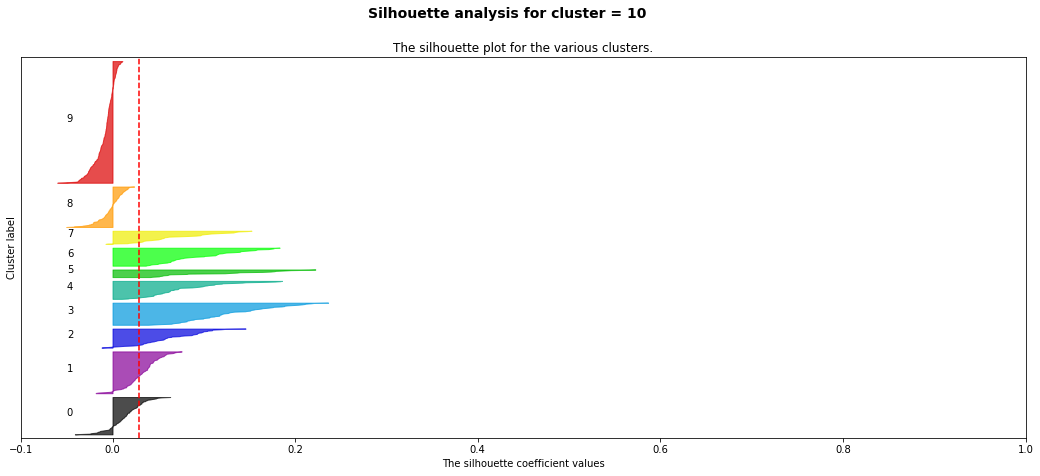

In [17]:
display_kmeans_silhouette(k_s)

In [18]:
from matplotlib.ticker import FuncFormatter
import pandas as pd
import numpy as np


def display_time_distribution_cluster(labels, labels_string):
    label_limit = ['2004-2007', '2007-2010','2010-2013','2013-2016', '2016-2018']
    limit_index = 0

    zeros = np.zeros((10, 5))
    df = pd.DataFrame(zeros, columns=label_limit)

    for i in range(len(labels)):
        if i <= limits[limit_index]:
            df.at[labels[i],label_limit[limit_index]] += 1
        else:
            limit_index += 1
            df.at[labels[i],label_limit[limit_index]] += 1

    # To percent
    df = df.apply(lambda x: x / x.sum(), axis=1)

    # Plot
    df.plot.barh(figsize=(20, 30), width=0.9)
    plt.title('Time distribution by cluster', fontsize= 24, color='gray')

    ## PlotSwagg ##
    plt.yticks(fontsize=14, rotation=0, color='gray')
    plt.xticks(fontsize=14, rotation=0, color='gray')

    # Cleanest Percent
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x))) 
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{}'.format(" ".join(labels_string[y]))))

    # Less border
    plt.gca().xaxis.grid(True)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_edgecolor('gray')
    plt.gca().spines['right'].set_edgecolor('gray')

    # Percent line under the barH
    plt.gca().set_axisbelow(True)

    plt.show()


In [19]:

# it looks like -> { doc_number : [partition_number, cluster_number] }
doc_clustering = {}

cluster_labels = k_s['labels']

numDoc = 0
for i in range(0, len(limits)):

    previousBound = 0
    if i > 0:
        previousBound = limits[i-1]
    clusterer = kmeans_silhouette(partitions_tfidf[i], nb_cluster)["labels"]
    for numDocItern in range(0, limits[i]-previousBound):
        doc_clustering[numDoc] = [i, clusterer[numDocItern]]
        numDoc+=1



In [20]:
len(doc_clustering)

991

In [21]:
# Allows to get list of documents number
# return [dou numbers]
# params : partition_number , cluster number
def get_doc(part, clust):
    docs = []
    for i in range(0,len(doc_clustering)):
        if doc_clustering[i][0] == part and doc_clustering[i][1] == clust:
            docs.append(i)
    return docs

In [22]:
# Get the partitions variable
# Here partitions[part][cluster] = list of docs numbe
partitions = []
for i in range(0, len(limits)):
    clusters = []
    for j in range(0, nb_cluster):
        clusters.append(get_doc(i,j))
    partitions.append(clusters)

In [23]:
partitions

[[[7, 8, 14, 25, 62, 63, 67, 77, 86, 97],
  [11, 20, 21, 36, 46, 47, 55, 83, 93, 99, 103, 109],
  [1, 24, 35, 52, 60, 69, 81, 85, 101, 102, 107, 108],
  [6, 22, 39, 41, 45, 50, 72, 88, 89, 91, 92, 96],
  [16, 17, 18, 26, 71, 73, 76, 78, 79, 105],
  [2, 27, 28, 29, 43, 48, 51, 61, 64, 95, 104, 110, 112],
  [0, 9, 19, 23, 31, 32, 33, 38, 40, 49, 57, 74, 80, 94, 98],
  [4, 37, 44, 53, 56, 58, 59, 65],
  [3, 5, 13, 30, 34, 42, 54, 75, 82, 84, 90, 106, 111],
  [10, 12, 15, 66, 68, 70, 87, 100, 113]],
 [[118,
   119,
   141,
   152,
   153,
   159,
   160,
   169,
   173,
   176,
   206,
   213,
   215,
   217,
   219,
   226,
   249,
   253,
   256,
   265,
   272,
   276,
   299],
  [120, 121, 123, 140, 149, 182, 203, 210, 212, 218, 235, 236, 239, 291, 296],
  [122,
   127,
   148,
   158,
   179,
   184,
   205,
   214,
   220,
   237,
   251,
   264,
   287,
   288,
   293,
   298],
  [125,
   126,
   128,
   138,
   143,
   146,
   162,
   171,
   192,
   204,
   231,
   243,
   255,
  

# Khi²

In [24]:
# tf_of_your_word = tf[numDoc][strWord]
tf = []
for doc in usable:
    tf_doc = {}
    for word in vectorizer.get_feature_names():
        tf_doc[word] = doc.count(word)
    tf.append(tf_doc)

In [25]:
# Number total of words
# nb_total_word[numPartition]
nb_total_word = []
nb = 0

for numDoc in range(0, len(usable)):
    for word in vectorizer.get_feature_names():
        nb += tf[numDoc][word]
    if numDoc+1 in limits:
        nb_total_word.append(nb)
        nb=0
    

In [26]:
nb_total_word

[4935, 7758, 7649, 9558, 13154]

In [27]:
tf[0]

{'actuel': 0,
 'adapte': 0,
 'adapter': 0,
 'aider': 0,
 'algorithme': 0,
 'ameliorer': 0,
 'analyser': 1,
 'annees': 0,
 'annotation': 0,
 'appel': 0,
 'appelee': 0,
 'application': 0,
 'appliqu': 0,
 'appliquee': 0,
 'appliquer': 0,
 'apport': 0,
 'apprentissage': 0,
 'approche': 0,
 'arbre': 0,
 'article': 0,
 'article methode': 0,
 'article present': 0,
 'artificiel': 0,
 'associer': 0,
 'attribut': 0,
 'automatique': 0,
 'automatiquement': 0,
 'base': 0,
 'base donneer': 0,
 'baser': 0,
 'baser donneer': 0,
 'bayesien': 0,
 'besoin': 0,
 'binaire': 0,
 'cadrer': 0,
 'calcul': 0,
 'calculer': 0,
 'capable': 0,
 'capacite': 0,
 'caracteriser': 0,
 'caracteristique': 1,
 'carte': 0,
 'celer': 0,
 'changement': 0,
 'choisir': 0,
 'choix': 0,
 'cibl': 0,
 'classe': 0,
 'classer': 0,
 'classification': 0,
 'classification supervisee': 0,
 'classifieur': 0,
 'classique': 0,
 'client': 0,
 'cluster': 0,
 'clustering': 0,
 'collection': 0,
 'combinaison': 0,
 'combiner': 0,
 'commun': 0,
 

In [28]:
# nb_word[num_partition][word]
nb_word = []

word_in_this_parti = {}
for word in vectorizer.get_feature_names():
    word_in_this_parti[word] = 0

for numDoc in range(0, len(usable)):
    for word in vectorizer.get_feature_names():
        word_in_this_parti[word] += tf[numDoc][word]
    if numDoc+1 in limits:
        nb_word.append(word_in_this_parti)
        word_in_this_parti = {}
        for word in vectorizer.get_feature_names():
            word_in_this_parti[word] = 0

In [29]:
len(nb_word)

5

In [30]:
# nb_word_by_cluster[numPartition][numCluster]
nb_word_by_cluster = []
for parti in partitions:
    nb_word_clus = []
    for cluster in parti:
        nb = 0
        for numDoc in cluster:
            for word in vectorizer.get_feature_names():
                nb += tf[numDoc][word]
        nb_word_clus.append(nb)
    nb_word_by_cluster.append(nb_word_clus)

In [31]:
# value_of_khi2 = khi2[numPartition][numCluster][word]
khi2 = []

for numParti in range(0, len(partitions)):
    khi2parti = []
    for numCluster in range(0, len(partitions[numParti])):
        khi2cluster = {}
        
        for word in vectorizer.get_feature_names():
            if nb_word_by_cluster[numParti][numCluster] == 0:
                khi2cluster[word] = 0
            else:
                word_in_this_parti[word] = 0
                E = nb_word[numParti][word]
                E =+ nb_word_by_cluster[numParti][numCluster]
                E = E/ nb_total_word[numParti]
                N = 0
                for numDoc in partitions[numParti][numCluster]:
                    N += tf[numDoc][word]
                khi2cluster[word] = (pow(N - E, 2)/E)        
        khi2parti.append(khi2cluster)
    khi2.append(khi2parti)

In [32]:
# list of your labels = labels[numPartition][numCluster]
labels = []

for numPartition in range(0, len(nb_word_by_cluster)):
    label_clus = []
    for numCluster in range(0, len(nb_word_by_cluster[numPartition])):
        label_clus.append(Counter(khi2[numPartition][numCluster]).most_common(5))
    labels.append(label_clus)

In [33]:
# Some clusters can be empty, so they have a score of 0 on each labels
labels

[[[('relation', 11177.224474231962),
   ('structur', 1718.8981143993253),
   ('pouvoir', 1462.7914198386557),
   ('information', 1227.3332608428398),
   ('apprentissage', 818.3625495457687)],
  [('reseau', 9734.282881584308),
   ('reseaux', 3351.870510450286),
   ('lien', 2711.437520759565),
   ('commun', 1407.1333970482249),
   ('mesure', 1407.1333970482249)],
  [('calcul', 1665.8138946260826),
   ('clustering', 1417.560344930342),
   ('cluster', 1417.560344930342),
   ('algorithme', 1189.327079210261),
   ('qualite', 624.7489859039728)],
  [('model', 7447.23863901607),
   ('modele', 5092.365221294552),
   ('prediction', 2252.669018762905),
   ('article', 1057.9221833198671),
   ('methode', 872.517120028728)],
  [('motif', 10524.106405141843),
   ('extraction', 1835.7314051418439),
   ('sequenc', 874.3564051418439),
   ('graph', 874.3564051418439),
   ('present', 689.0907801418439)],
  [('recommandation', 8755.3831251293),
   ('utilisateur', 2754.5873136109744),
   ('system', 1020.236

# Diachronic Analysis

In [34]:
labels_cluster = []

for i in range(nb_cluster):
    labels_cluster.append('')
    for j in range(len(labels[0][i])):
        labels_cluster[i] += ''.join([t for t in labels[0][i][j][0] ]) +' '

labels_cluster

['relation structur pouvoir information apprentissage ',
 'reseau reseaux lien commun mesure ',
 'calcul clustering cluster algorithme qualite ',
 'model modele prediction article methode ',
 'motif extraction sequenc graph present ',
 'recommandation utilisateur system text document ',
 'cluster clustering temporel present graph ',
 'text textuel corpu pouvoir contenir ',
 'web text apprentissage system processus ',
 'similarite concept type treillis classification ']

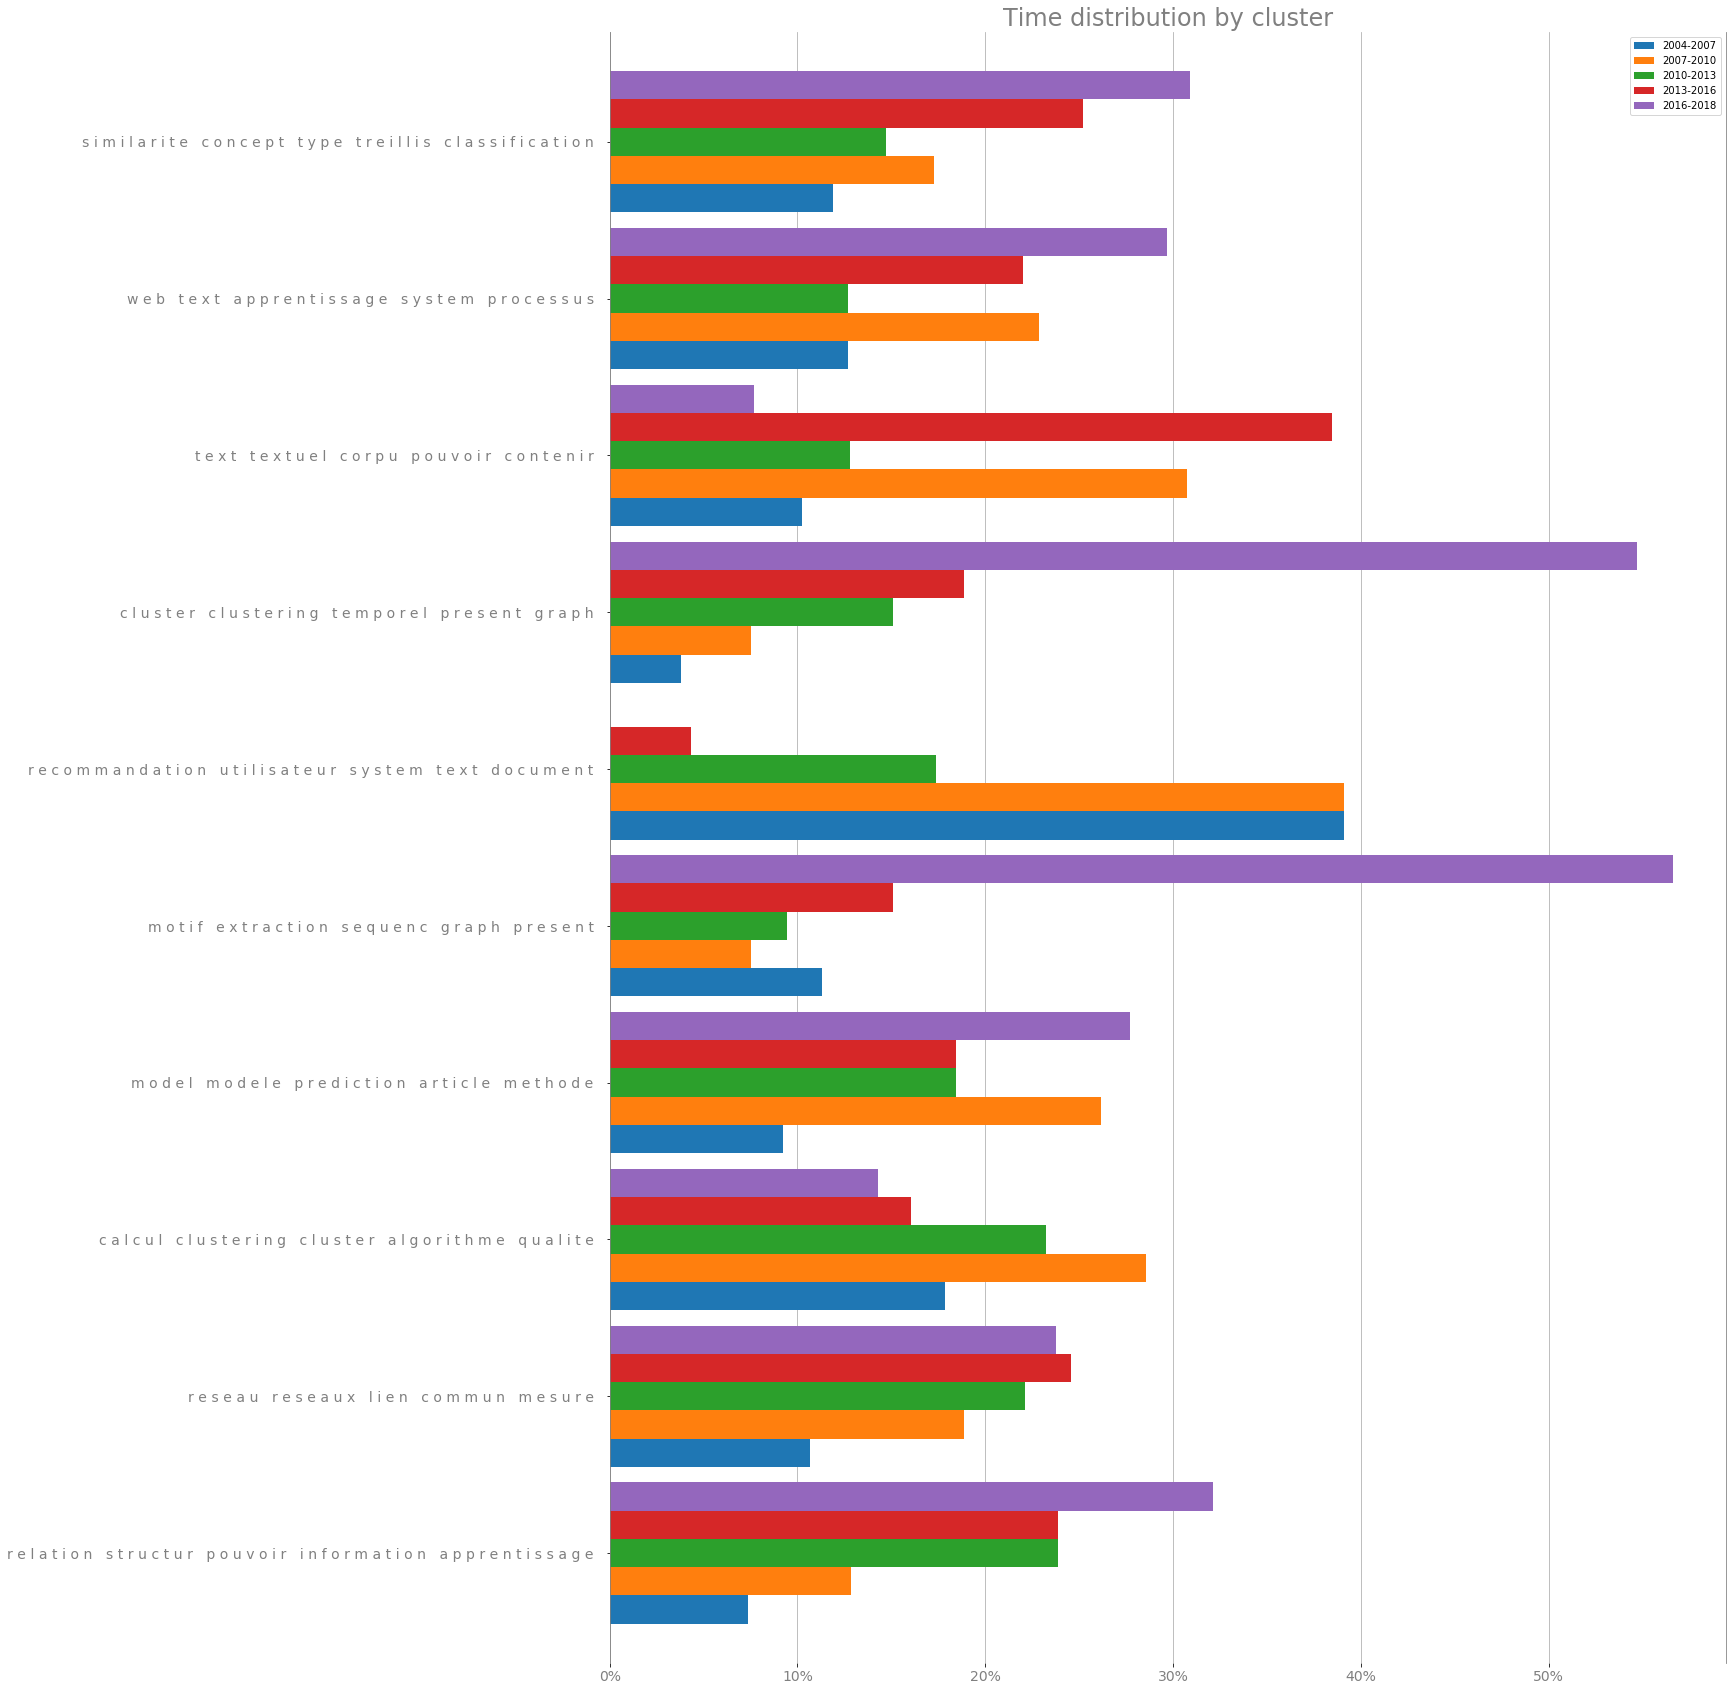

In [35]:
# Low level analysis

display_time_distribution_cluster(k_s['labels'], labels_cluster)

In [36]:

def inter(listA, listB):
    return np.intersect1d(listA, listB)
    
# cluster_t and cluster_s must be in two different partitions
def proba(num_cluster_t, num_cluster_s, num_partition_T, num_partition_S):
    total_inter = 0
    total_t = 0
    for f in range(0, len(labels[num_partition_T][num_cluster_t])):
        for f_s in labels[num_partition_S][num_cluster_s]:
            if labels[num_partition_T][num_cluster_t][f][0] == f_s[0]:
                total_inter += labels[num_partition_T][num_cluster_t][f][1]
                break
        total_t += labels[num_partition_T][num_cluster_t][f][1]
    if total_t == 0:
        return 0
    return total_inter / total_t
    

def P_A(num_cluster_s, num_partition_T, num_partition_S):
    # first, we have to know what are the cluster which got the label
    total = 0
    nb_computation = 0
    for label_s in labels[num_partition_S][num_cluster_s]:
        for num_cluster_t in range(0, len(partitions[num_partition_T])):
            if label_s in labels[num_partition_T][num_cluster_t]:
                total += proba(num_cluster_t, num_cluster_s, num_partition_T, num_partition_S)
                nb_computation += 1
    if nb_computation == 0:
        return 0
    return total / nb_computation

# Define a coeficient for the activity 
def activity(num_partition_S, num_partition_T):
    res = 0
    for num_cluster_s in range(0, len(partitions[num_partition_S])):
        res += P_A(num_cluster_s, num_partition_T, num_partition_S)
    return res / len(partitions[num_partition_S])

# Ecart-type, but it isn't very usefull xD
sigma_t = 0.01
sigma_s = 0.01

# Our Graal
def similar(num_cluster_t, num_partition_T, num_cluster_s, num_partition_S):
    cond1 = proba(num_cluster_t, num_cluster_s, num_partition_T, num_partition_S) > P_A(num_cluster_s, num_partition_T, num_partition_S)
    cond2 = proba(num_cluster_t, num_cluster_s, num_partition_T, num_partition_S) > activity(num_partition_S, num_partition_T) + sigma_s
    
    cond3 = proba(num_cluster_t, num_cluster_s, num_partition_T, num_partition_S) > P_A(num_cluster_s, num_partition_T, num_partition_S)
    cond4 = proba(num_cluster_t, num_cluster_s, num_partition_T, num_partition_S) > activity(num_partition_T, num_partition_S) + sigma_t
    return cond1 and cond2 and cond3 and cond4
    

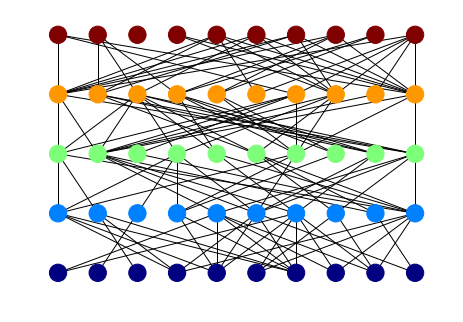

In [37]:
# Plot the diachronic analysis results

# Node coloring source: https://stackoverflow.com/questions/13517614/draw-different-color-for-nodes-in-networkx-based-on-their-node-value#13517947

# The more the partition is high, the more the partition is recent

val_map = {}
values = []

g = nx.Graph()
for n_part in range(0, len(limits)):
    for n_clus in range(0, nb_cluster):
        node_str = '('+str(n_clus)+','+str(n_part)+')'
        g.add_node(node_str, posxy=(n_clus, n_part), partition = n_part)
        val_map[node_str] = n_part/len(limits)

values = [val_map.get(node, 0.25) for node in g.nodes()]

for numParti in range(0, len(partitions)-1):
    for num_cluster_t in range(0, nb_cluster):
        for num_cluster_s in range(0, nb_cluster):
            if similar(num_cluster_t, numParti, num_cluster_s, numParti+1):
                #print("("+str(num_cluster_t)+","+str(numParti)+") est similaire à ("+str(num_cluster_s)+","+str(numParti+1)+")")
                g.add_cycle(["("+str(num_cluster_t)+","+str(numParti)+")", "("+str(num_cluster_s)+","+str(numParti+1)+")"])
                
positions = nx.get_node_attributes(g,'posxy')
nx.draw(g, positions, node_size=3000/nb_cluster, cmap=plt.get_cmap('jet'), node_color=values)


In [38]:
print(labels[0][1])
labels[0][1][0][1]

[('reseau', 9734.282881584308), ('reseaux', 3351.870510450286), ('lien', 2711.437520759565), ('commun', 1407.1333970482249), ('mesure', 1407.1333970482249)]


9734.282881584308